## Imports and Set up


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# df = pd.read_csv("../data/flocking_250305.csv")
df = pd.read_csv("../mesa/flocking_250414_v2.csv")
# df_1 = pd.read_csv("flocking_250409_v1.csv")
# df_2 = pd.read_csv("flocking_250409_v2.csv")
# df_3 = pd.read_csv("flocking_250409_v3.csv")
# df = pd.concat([df_1, df_2, df_3], ignore_index=True)
# print(f"Number of rows in df: {len(df)}")

Using device: cpu


In [2]:
df.head()

,Step,AgentID,Angle,Vision,Separation,CohereFactor,SeparateFactor,MatchFactor,NeighborDiffSum,NeighborInfo,run
0,0,1,3.647332,10,2,0.03,0.015,0.05,"[0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
1,0,2,5.391761,10,2,0.03,0.015,0.05,"[0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
2,0,3,2.961175,10,2,0.03,0.015,0.05,"[0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
3,0,4,3.676244,10,2,0.03,0.015,0.05,"[0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
4,0,5,4.843830,10,2,0.03,0.015,0.05,"[0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0


## Prepare Data

In [3]:
# df["NeighborDiffSum"] = df["NeighborDiffSum"].apply(lambda x: eval(x) if isinstance(x, str) else x)
df["NeighborInfo"] = df["NeighborInfo"].apply(lambda x: eval(x) if isinstance(x, str) else x)
df["Angle"] = df["Angle"].astype(float)

"""
group data according to each time step
"""
grouped = df.groupby("Step").agg(list)
# neighbor_diff_sum = np.array(grouped["NeighborDiffSum"].to_list())  # Shape: (num_steps, num_agents, 2)
neighbor_info = np.array(grouped["NeighborInfo"].to_list())  # Shape: (num_steps, num_agents, 2)
angles = np.array(grouped["Angle"].to_list()).reshape(len(grouped), len(grouped.iloc[0]["Angle"]), 1)  # Shape: (num_steps, num_agents, 1)

"""
this makes sure angle difference wraps correctly within [-pi. pi]
"""
# def angle_difference(theta2, theta1):
#     return np.arctan2(np.sin(theta2 - theta1), np.cos(theta2 - theta1))
# delta_angle = np.zeros_like(angles)
# delta_angle[1:] = angle_difference(angles[1:], angles[:-1]) # Shape: (num_steps, num_agents, 1)

# grouped["deltaAngle"] = delta_angle.reshape(len(grouped), -1).tolist()

# X_train, X_test, y_train, y_test = train_test_split(neighbor_diff_sum, delta_angle, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(neighbor_info, angles, test_size=0.2, random_state=42)

# to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

## For Debugging

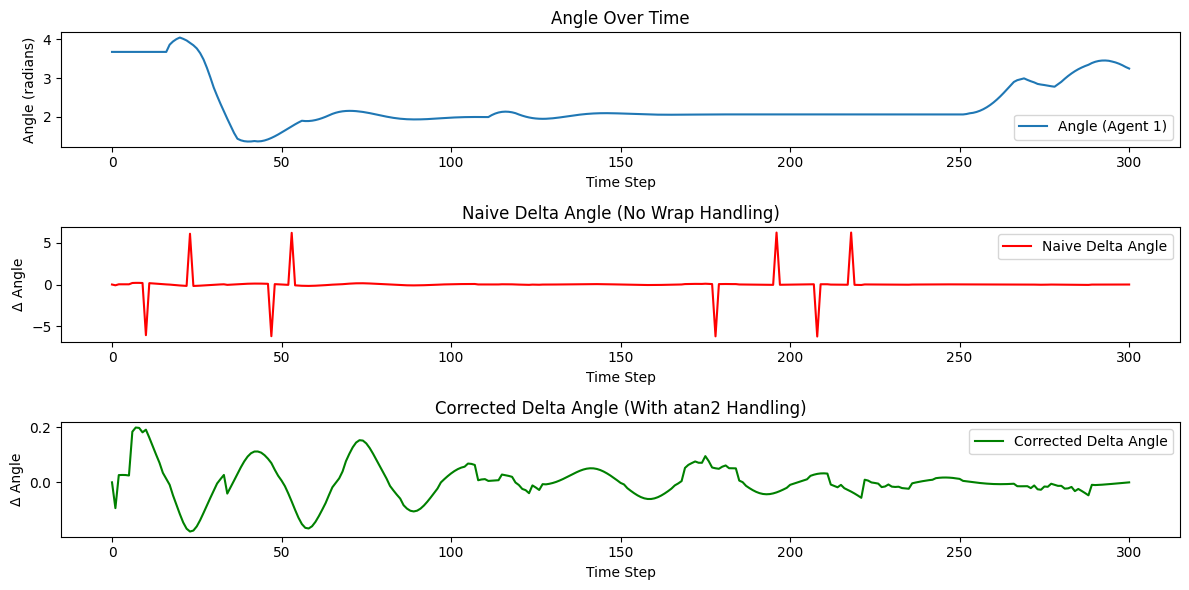

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Compute incorrect delta angles (naive subtraction)
naive_delta_angle = np.zeros_like(angles)
naive_delta_angle[1:] = angles[1:] - angles[:-1]

# Compute corrected delta angles (using atan2)
corrected_delta_angle = np.zeros_like(angles)
corrected_delta_angle[1:] = np.arctan2(np.sin(angles[1:] - angles[:-1]), np.cos(angles[1:] - angles[:-1]))

# Plot angles over time
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(angles[:, 3, 0], label="Angle (Agent 1)")
plt.xlabel("Time Step")
plt.ylabel("Angle (radians)")
plt.title("Angle Over Time")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(naive_delta_angle[:, 1, 0], label="Naive Delta Angle", color="red")
plt.xlabel("Time Step")
plt.ylabel("Δ Angle")
plt.title("Naive Delta Angle (No Wrap Handling)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(corrected_delta_angle[:, 1, 0], label="Corrected Delta Angle", color="green")
plt.xlabel("Time Step")
plt.ylabel("Δ Angle")
plt.title("Corrected Delta Angle (With atan2 Handling)")
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
angles_df = pd.DataFrame(angles.reshape(len(grouped), -1))  # col: agent number; row: timestep
# delta_angle_df = pd.DataFrame(delta_angle.reshape(len(grouped), -1))  # Each column is an agent's deltaAngle

In [9]:
angles_df.head(30)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,3.647332,5.391761,2.961175,3.676244,4.843830,5.097544,3.064299,1.724186,6.148051,3.19055,...,1.442918,3.949304,1.691532,2.429699,0.509753,4.677277,0.335139,5.273547,3.949875,1.674094
1,3.524074,5.298383,3.013351,3.676244,4.939299,5.097544,2.888943,1.969558,6.065742,3.19055,...,1.442918,3.949304,1.691532,2.429699,5.941276,4.677277,0.335139,5.523167,3.949875,1.674094
2,3.397751,5.324663,3.046207,3.676244,4.923893,5.097544,2.670803,2.174175,6.083035,3.19055,...,1.442918,3.949304,1.691532,2.429699,5.662678,4.677277,0.335139,5.789397,3.949875,1.674094
3,3.284814,5.351430,3.066449,3.676244,4.887594,5.097544,2.454697,2.352684,6.075740,3.19055,...,1.442918,3.949304,1.691532,2.429699,5.433775,4.677277,0.335139,6.015245,3.949875,1.674094
4,3.173176,5.377909,3.075256,3.676244,4.918094,5.097544,2.254358,2.505061,6.045787,3.19055,...,1.442918,4.178026,1.691532,2.429699,5.261683,4.677277,0.335139,6.193635,3.949875,1.840053
5,3.090970,5.402766,3.073557,3.676244,4.921408,5.097544,2.076785,2.505061,5.989574,3.19055,...,1.442918,4.369044,1.691532,2.429699,5.141157,4.677277,0.335139,0.043801,3.949875,1.979587
6,3.033314,5.586216,3.050261,3.676244,4.898702,4.950099,1.973519,2.505061,5.934108,3.19055,...,1.442918,4.528163,1.691532,2.429699,5.063950,4.677277,0.335139,0.137370,3.949875,2.113405
7,2.996382,5.784753,2.999337,3.676244,4.848781,4.919774,1.891676,2.505061,5.868912,3.19055,...,1.442918,4.476503,1.691532,2.429699,5.022924,4.677277,0.335139,0.074657,3.949875,2.257079
8,2.978099,5.981955,2.913950,3.676244,4.768018,4.942322,1.825241,2.505061,5.799059,3.19055,...,1.442918,4.421626,1.691532,2.429699,5.011754,4.677277,0.335139,6.276995,3.949875,2.416088
9,2.977631,6.163048,2.787540,3.676244,4.640578,4.951048,1.771239,2.505061,5.729134,3.19055,...,1.442918,4.360111,1.691532,2.429699,5.026639,4.677277,0.335139,6.178442,3.949875,2.593462


In [10]:
# delta_angle_df.head(10)

In [11]:
np.arctan2(-0.09105, 0.9958)

np.float64(-0.09118049177939738)

## Define Model

In [12]:
# define nn
hidden_size_1 = 16
hidden_size_2 = 8
hidden_size_3 = 4

model = nn.Sequential(
    nn.Linear(8, hidden_size_1),
    nn.ReLU(),
    nn.Linear(hidden_size_1, hidden_size_2),
    nn.ReLU(),
    nn.Linear(hidden_size_2, 1)
)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Define Model

In [17]:
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor.view(-1, 8))
    loss = criterion(outputs, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/1000], Loss: 1.9862
Epoch [20/1000], Loss: 1.9853
Epoch [30/1000], Loss: 1.9844
Epoch [40/1000], Loss: 1.9835
Epoch [50/1000], Loss: 1.9826
Epoch [60/1000], Loss: 1.9818
Epoch [70/1000], Loss: 1.9809
Epoch [80/1000], Loss: 1.9801
Epoch [90/1000], Loss: 1.9792
Epoch [100/1000], Loss: 1.9784
Epoch [110/1000], Loss: 1.9776
Epoch [120/1000], Loss: 1.9767
Epoch [130/1000], Loss: 1.9759
Epoch [140/1000], Loss: 1.9751
Epoch [150/1000], Loss: 1.9743
Epoch [160/1000], Loss: 1.9735
Epoch [170/1000], Loss: 1.9728
Epoch [180/1000], Loss: 1.9720
Epoch [190/1000], Loss: 1.9712
Epoch [200/1000], Loss: 1.9704
Epoch [210/1000], Loss: 1.9696
Epoch [220/1000], Loss: 1.9689
Epoch [230/1000], Loss: 1.9681
Epoch [240/1000], Loss: 1.9673
Epoch [250/1000], Loss: 1.9665
Epoch [260/1000], Loss: 1.9658
Epoch [270/1000], Loss: 1.9650
Epoch [280/1000], Loss: 1.9642
Epoch [290/1000], Loss: 1.9634
Epoch [300/1000], Loss: 1.9626
Epoch [310/1000], Loss: 1.9619
Epoch [320/1000], Loss: 1.9611
Epoch [330/1000],

## Evaluate the model

In [18]:
with torch.no_grad():
    y_pred = model(X_test_tensor.view(-1, 8))
    test_loss = criterion(y_pred, y_test_tensor.view(-1, 1))
    print(f'Test Loss: {test_loss.item():.4f}')
    print(y_pred)

Test Loss: 1.9098
tensor([[3.0856],
        [4.8654],
        [2.9818],
        ...,
        [3.1850],
        [2.7235],
        [3.2144]])


## Save the model

In [20]:
torch.save(model, '../models/20250414_v3')